In [27]:
import pandas as pd
import numpy as np

In [28]:
# jupyter
train_df = pd.read_csv('./data01/train.csv/train.csv')
test_df = pd.read_csv('./data01/test.csv/test.csv')
submission_df = pd.read_csv('./data01/submission.csv')

# 데이터 설명
## 기초 설명

한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 테스트 파일에서 각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합을 예측해야 합니다.


예측한 금액만큼 100일간 대출을 진행합니다. 만약 예측한 금액보다 실제 매출이 적게 발생한다면 원금에 손실을 보게 됩니다. 실제 매출이 예측한 금액 이상으로 발생한다면, 연이율 13%의 이자가 발생합니다.


## Data

train.csv - 카드 매출 내역, 2016-08-01부터 2018-07-31까지.


test.csv - train.csv랑 같은 형식. test.csv랑 train.csv의 store_id가 같아도 같은 상점인 것은 아님.

(월에 최소 5일 이상 데이터가 있는 상점만을 문제에 포함.)


submission.csv – store_id와 total_sales 두 개의 열로 구성. store_id는 test.csv의 store_id와 대응.

ore_id가 같아도 같은 상점인 것은 아님.

(월에 최소 5일 이상 데이터가 있는 상점만을 문제에 포함.)


submission.csv – store_id와 total_sales 두 개의 열로 구성. store_id는 test.csv의 store_id와 대응.

## 칼럼

- store_id: 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
- date: 거래 일자
- time: 거래 시간
- card_id: 카드 번호의 hash 값
- amount: 매출 금액, 음수인 경우 취소 거래
- installments: 할부 개월 수. 일시불은 빈 문자열
- days_of_week: 요일, 월요일이 0, 일요일은 6
- holiday: 1이면 공휴일, 0이면 공휴일 아님

In [29]:
train_df.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


In [30]:
test_df.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0


In [31]:
submission_df.head()

,store_id,total_sales
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [32]:
train_df['days_of_week'].unique()

array([2, 0, 1, 3, 4, 5, 6], dtype=int64)

In [33]:
train_df.shape

(3362796, 8)

In [34]:
test_df.shape

(473392, 8)

In [35]:
train_df_origin = train_df.copy()

In [36]:
train_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   store_id      3362796 non-null  int64  
 1   date          3362796 non-null  object 
 2   time          3362796 non-null  object 
 3   card_id       3362796 non-null  object 
 4   amount        3362796 non-null  int64  
 5   installments  16860 non-null    float64
 6   days_of_week  3362796 non-null  int64  
 7   holyday       3362796 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [40]:
train_df['datetime'] = pd.to_datetime(train_df['date'] + ' ' + train_df['time'])
train_df = train_df.drop(['date', 'time'], axis=1)

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   store_id      int64         
 1   card_id       object        
 2   amount        int64         
 3   installments  float64       
 4   days_of_week  int64         
 5   holyday       int64         
 6   datetime      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 179.6+ MB


In [42]:
train_df = train_df.set_index('datetime')

In [43]:
train_df.head()

,store_id,card_id,amount,installments,days_of_week,holyday
datetime,,,,,,
2016-12-14 18:05:31,0,d297bba73f,5,NaN,2,0
2016-12-14 18:05:54,0,d297bba73f,-5,NaN,2,0
2016-12-19 12:42:31,0,0880849c05,144,NaN,0,0
2016-12-19 12:48:08,0,8b4f9e0e95,66,NaN,0,0
2016-12-19 13:31:08,0,7ad237eed0,24,NaN,0,0


In [44]:
train_df['store_id'].value_counts()

0       68773
753     39318
105     36063
1342    33335
428     33285
        ...  
1605        1
991         1
1263        1
1530        1
632         1
Name: store_id, Length: 1775, dtype: int64

In [46]:
test_df['store_id'].value_counts()

80     32959
77     26163
88     21879
34     20418
153    17651
       ...  
32        60
197       50
130       49
93        49
64        44
Name: store_id, Length: 200, dtype: int64

In [54]:
store_id_count = train_df['store_id'].value_counts()

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='store_id', ylabel='Density'>

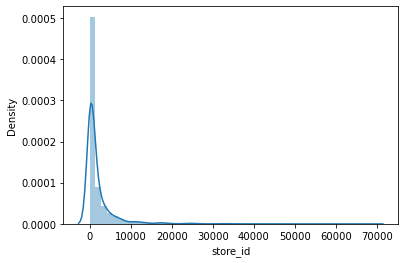

In [55]:
import seaborn as sns

sns.distplot(store_id_count)

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='store_id', ylabel='Density'>

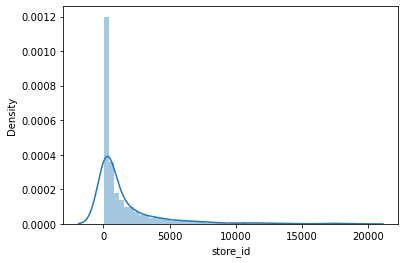

In [61]:
sns.distplot(store_id_count[store_id_count < 20000])

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='store_id', ylabel='Density'>

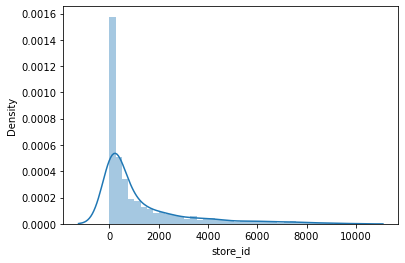

In [62]:
sns.distplot(store_id_count[store_id_count < 10000])

C:\Users\yrc92\.conda\envs\ai_study_py37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='store_id', ylabel='Density'>

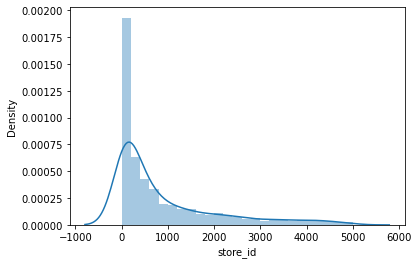

In [63]:
sns.distplot(store_id_count[store_id_count < 5000])

데이터가 특정 일 수 미만으로 있으면 제거해야 할 것 같다.

In [70]:
train_df.resample('D')['store_id'].unique()

datetime
2016-08-01    [526, 942, 723, 268, 1197, 378, 188, 361, 428,...
2016-08-02    [216, 268, 782, 1044, 736, 384, 560, 8, 428, 1...
2016-08-03    [1337, 378, 110, 810, 361, 1427, 188, 24, 511,...
2016-08-04    [105, 185, 504, 452, 1368, 724, 1345, 1097, 78...
2016-08-05    [1343, 428, 946, 64, 1044, 532, 394, 834, 1464...
                                    ...                        
2018-07-27    [277, 1501, 542, 37, 1465, 503, 678, 1778, 174...
2018-07-28    [35, 1080, 293, 43, 408, 1606, 1274, 407, 120,...
2018-07-29    [644, 1094, 408, 196, 1080, 1575, 1315, 367, 6...
2018-07-30    [0, 1687, 134, 588, 942, 526, 1266, 196, 1587,...
2018-07-31    [1182, 1479, 1667, 1200, 191, 1786, 1606, 942,...
Freq: D, Name: store_id, Length: 730, dtype: object